# Model validation Wave Heights

Note: this notebook requires the model output data.

This notebook compares the point data extracted from the model results against the corresponding observations.

<div class="alert alert-warning" role="alert">
  <strong>⚠️ Important Disclaimer</strong><br><br>
  This model setup is a <strong>simplified version</strong> of a detailed model developed by DHI. It does <strong>not</strong> resolve fine-scale processes and is <strong>not calibrated</strong> for operational use. Use is limited to <strong>educational and research purposes only</strong> — results should <strong>not</strong> inform decision-making. Performance shown here does <strong>not</strong> represent that of DHI’s high-resolution models.
</div>

### Load packages

In [36]:
import mikeio
import modelskill as ms
import matplotlib.pyplot as plt 
import helper as h
import pandas as pd

### Define metrics

In [37]:
ms.options.metrics.list = ["bias", "rmse", "mae", "cc", "si", "r2"]

Instead of reading the entire dfsu (`Area.dfsu`), we can simply load the outputted points (dfs0) since they correspond to the locations we have observations from.

### Define paths

In [38]:
#mr_fldr = "../output/"    
mr_fldr = "../output_sample/"     # use this if you have not downloaded the full data from Zenodo yet
fig_fldr = "../figures/" 
save_fig = False if "sample" in mr_fldr else True
show_fig = True

### Load points data

Model results data are stored in a dfs0 file. We can use [MIKE IO](https://dhi.github.io/mikeio) read the data to a MIKE IO Dataset.

Note: The first two spin-up days are excluded.

In [39]:
ds = mikeio.read(f"{mr_fldr}Points.dfs0", items="*Sign*", time = slice("2022-01-03", None))

## Compare to wave height station observations

The [ModelSkill package](https://dhi.github.io/modelskill/) can be used to compare model results with observations.

In [40]:
swhlist = h.get_swh_point_obs(meas_fldr = "../observations/measurements/", obs_fldr = "../observations/", station_file="stations_subset.csv")

### Spatial coverage

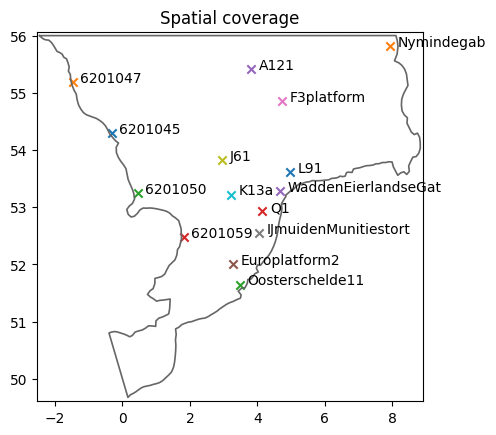

In [41]:
msh = mikeio.open("../input/Mesh_8000_elems.mesh")
ms.plotting.spatial_overview(swhlist, mod=msh);

Match the right model result timeseries and observation.

In [44]:
mr_fn = f"{mr_fldr}Area.dfsu"
mr = ms.DfsuModelResult(mikeio.read(mr_fn,time=slice("2022-01-03","2023-12-31"))[0], name="MIKE21")

cmps = []
for o in swhlist:
    print(f"Processing {o.name}...")
    mr = ms.PointModelResult(ds[o.name+": Sign. Wave Height"], name="MIKE21")
    try:
        cmp = ms.match(obs=o, mod=mr)
    except Exception as e:
        print("Station ", o.name)
        print(e)
    cmps.append(cmp)
cc = ms.ComparerCollection(cmps)

Processing 6201045...
Processing 6201047...
Processing 6201050...
Processing 6201059...
Processing A121...
Processing Europlatform2...
Processing F3platform...
Processing IJmuidenMunitiestort...
Processing J61...
Processing K13a...
Processing L91...
Processing Nymindegab...
Processing Oosterschelde11...
Station  Oosterschelde11
No data left after trimming to 2022-01-02 23:59:59 - 2022-01-09 23:30:01
Processing Q1...
Station  Q1
No data left after trimming to 2022-01-02 23:59:59 - 2022-01-09 23:30:01
Processing WaddenEierlandseGat...


In [49]:
cc

<ComparerCollection>
Comparers:
0: 6201045 - Significant Wave Height [meter]
1: 6201047 - Significant Wave Height [meter]
2: 6201050 - Significant Wave Height [meter]
3: 6201059 - Significant Wave Height [meter]
4: A121 - Significant Wave Height [meter]
5: Europlatform2 - Significant Wave Height [meter]
6: F3platform - Significant Wave Height [meter]
7: IJmuidenMunitiestort - Significant Wave Height [meter]
8: J61 - Significant Wave Height [meter]
9: K13a - Significant Wave Height [meter]
10: L91 - Significant Wave Height [meter]
11: Nymindegab - Significant Wave Height [meter]
12: WaddenEierlandseGat - Significant Wave Height [meter]

## Skill table (you could add the mean_skill after, it is always a good summary)

In [45]:
cc.skill().round(3)

,n,bias,rmse,mae,cc,si,r2
observation,,,,,,,
6201045,336,0.280,0.359,0.301,0.979,0.139,0.895
6201047,336,0.238,0.324,0.264,0.959,0.187,0.779
6201050,336,0.155,0.252,0.213,0.928,0.191,0.776
6201059,336,0.307,0.380,0.319,0.813,0.250,-0.518
A121,1006,0.409,0.531,0.431,0.961,0.118,0.730
Europlatform2,1005,0.203,0.321,0.259,0.943,0.121,0.760
F3platform,1004,0.251,0.430,0.334,0.952,0.112,0.827
IJmuidenMunitiestort,989,0.048,0.311,0.238,0.933,0.126,0.868
J61,1006,0.204,0.432,0.333,0.935,0.141,0.796


In [ ]:
# TODO: Add mean_skill 

## Example timeseries

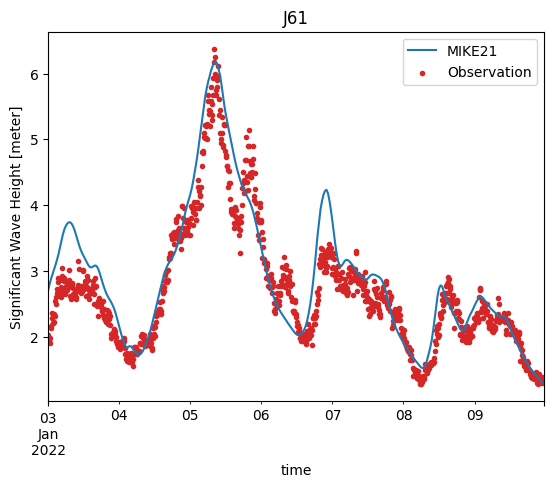

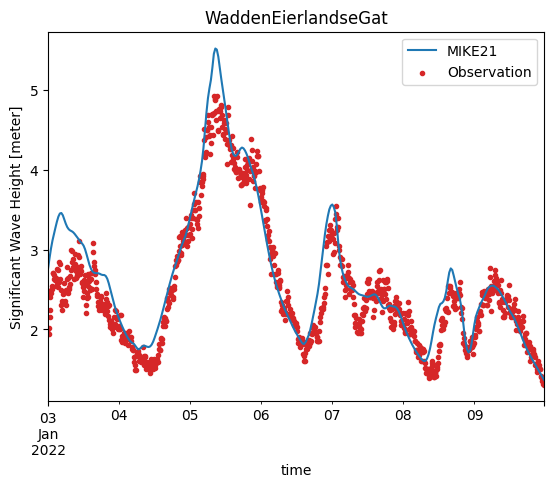

In [46]:
t_plot = slice("2022-12-01","2022-12-10") if "2022-12-01" in ds.time else slice(None, None)
cc["J61"].sel(time=t_plot).plot.timeseries();

cc["WaddenEierlandseGat"].sel(time=t_plot).plot.timeseries();
# Save fig
if save_fig and show_fig:
    plt.savefig(fig_fldr + "WaddenEierlandseGat_timeseries.png", dpi=300)
if not show_fig:
    plt.close()

## Scatter plots

Text(0.5, 1.0, 'MIKE21 vs observations')

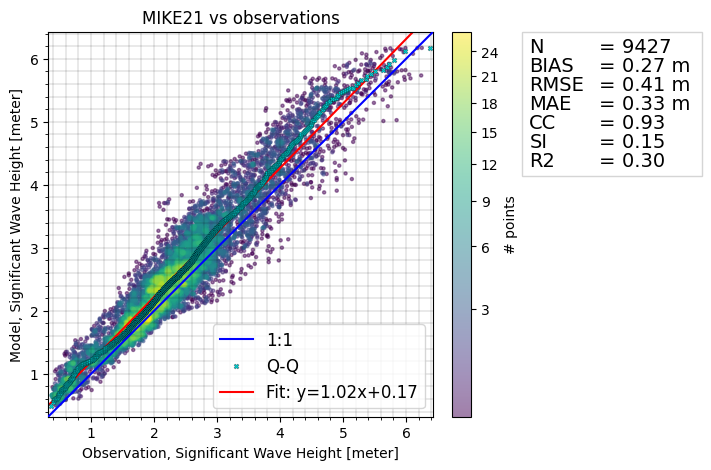

In [47]:
cc.plot.scatter(skill_table=True, show_points=True, figsize=(6,5))
plt.title("MIKE21 vs Observations")

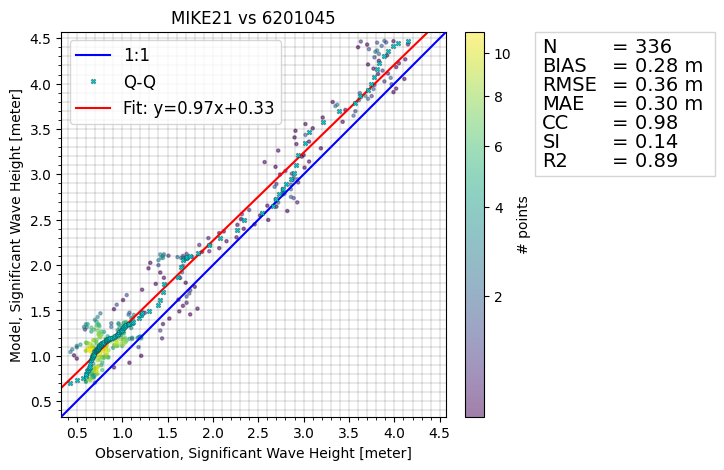

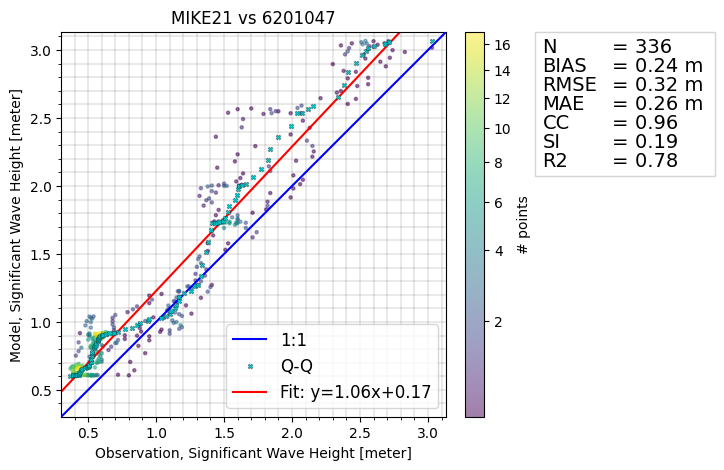

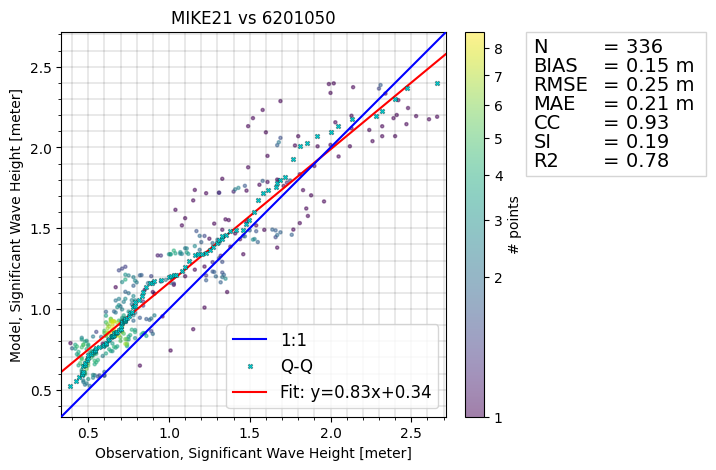

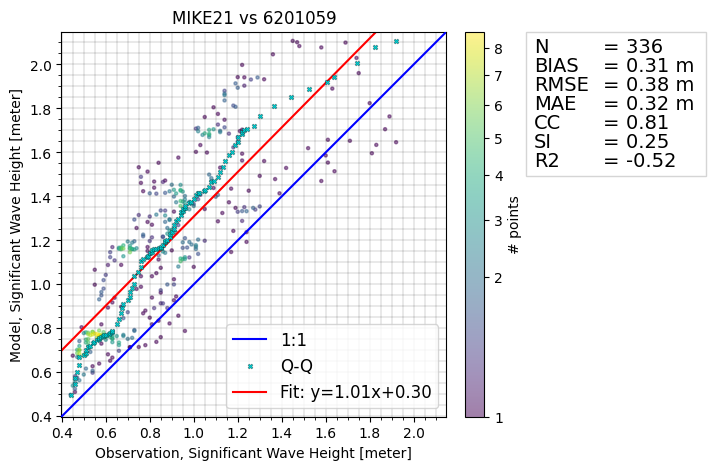

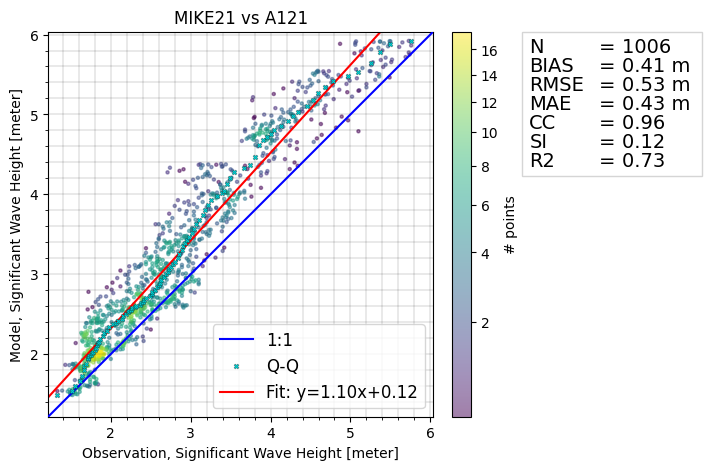

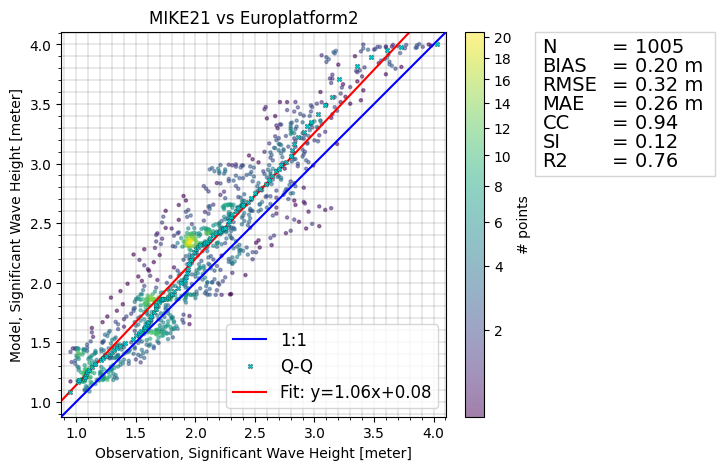

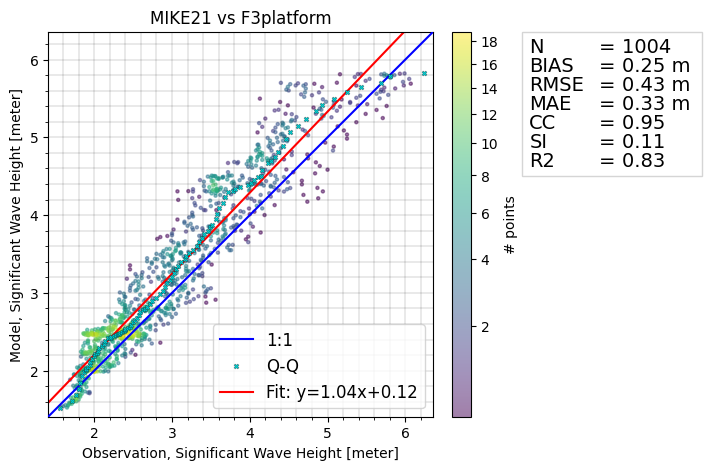

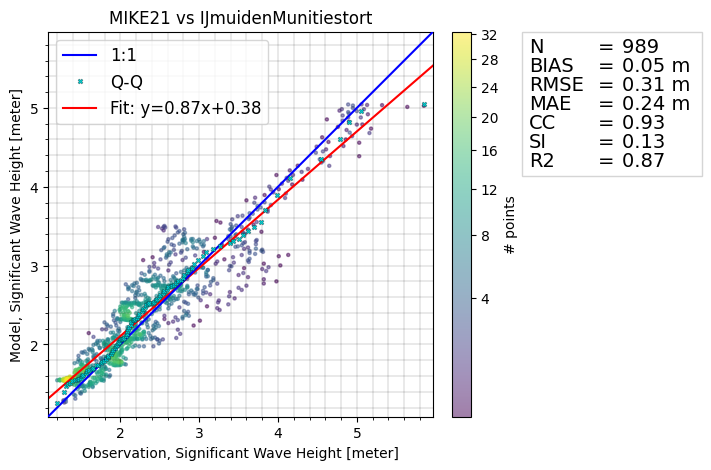

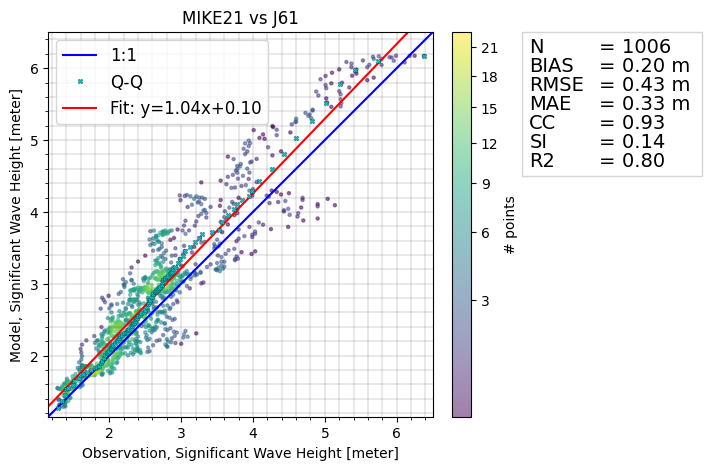

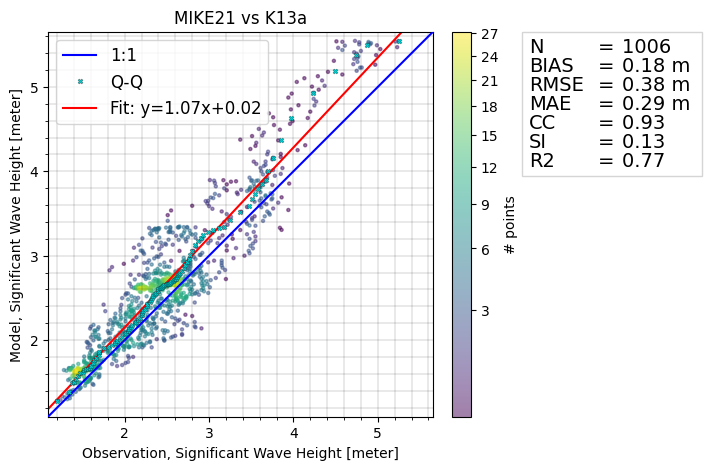

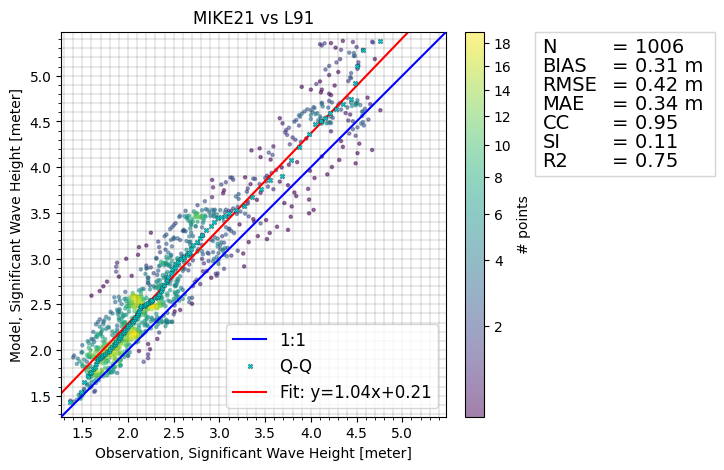

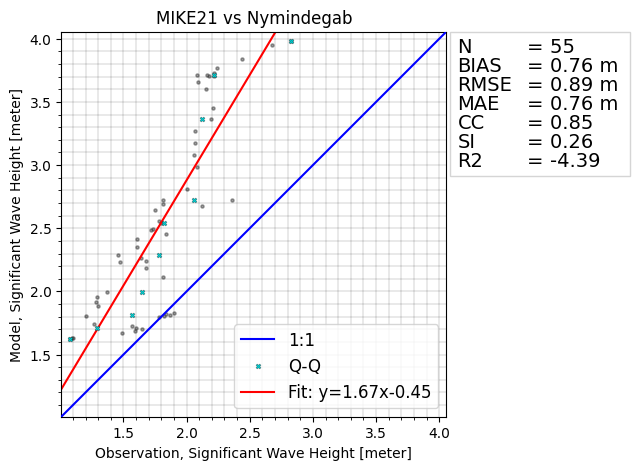

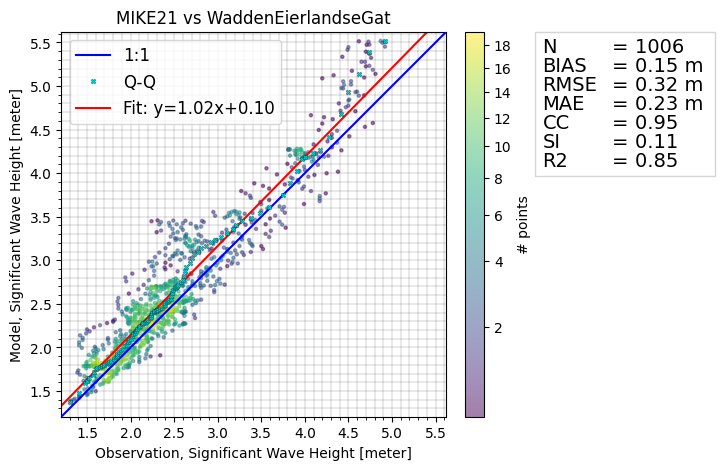

In [48]:
n_points_shown = 10000
for cmp in cc:
    cmp.plot.scatter(skill_table=True, show_points=n_points_shown, figsize=(6,5), bins=40);
    if save_fig:
        plt.savefig(f"{fig_fldr}swh_comparison_{cmp.name}.png", bbox_inches='tight');
        print(f"fig saved to: {fig_fldr}swh_comparison_{cmp.name}.png")
    if show_fig:
        plt.show()
    else:
        plt.close()